In [8]:
import re
import json
import editdistance
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from PIL import Image
import os
from matplotlib import font_manager as fm, rcParams

from nltk.tokenize import sent_tokenize
from unidecode import unidecode
from rich import print

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

def visualize_names(df, people=False, save=None):
    if people:
        df = df.loc[df.Nr_Words > 1, :]
    
    plt.figure(figsize=(12, 5))
    norm = TwoSlopeNorm(vmin=-1, vcenter=0.0, 
                        vmax=1)
    colors = [plt.cm.bwr(norm(c)) for c in df.Sentiment.head(15)]
    ax = sns.barplot(x='Sentiment', y='Word', data=df.head(15), palette=colors, edgecolor='black')
    plt.tight_layout()
    plt.xlabel("Sentiment")
    plt.ylabel("")
    
    if save:
        plt.savefig(f"../images/{save}.png", dpi=300)
    else:
        plt.show()
    
    
def preprocess_names(names, nr_sentences, title):
    df = pd.DataFrame(names, columns=["Word", "Prob", "Sentiment"])

    # Preprocessing
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = [unidecode(word) for word in df.Word]
    df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
    df.Word = [re.sub(r"\b[a-zA-Z]\b", "", word).strip() for word in df.Word.values]
    df = df.loc[df.Word != "Disney", :]
    df = df.loc[df.Word.str.len() >= 3, :]
    df = df.loc[df.Prob > 0.9, :]
    df = preprocess_titles(df)

    # # Finishing up
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df["Count_Percentage"] = df.Count / nr_sentences * 100
    df["Title"] = title
    df = df.sort_values("Count", ascending=False)
    df["Nr_Words"] = df.apply(lambda row: len(row.Word.split(" ")), 1)
    
    return df

def get_nr_sentences(docs):
    total_nr_sentences = 0
    for doc in docs:
        sentences = sent_tokenize(doc)
        total_nr_sentences += len(sentences)
    return total_nr_sentences

def extract_popular_characters(processed_names, sentences, names, name_in_title=False, min_sentences=1000):
    result = pd.DataFrame(columns=processed_names["Aladdin"].columns)

    for title in names:
        if sentences[title] >= min_sentences:
            to_append = processed_names[title]
            
            if not name_in_title:
#                 to_append = to_append.loc[to_append.Word != title, :]
#                 to_append = to_append.loc[~to_append.Word.isin(title.split(" "))]
#                 to_append = to_append.loc[~to_append.Word.isin(title)]
                to_append['is_in_Title'] = to_append.apply(lambda x: x.Word in x.Title, axis=1)
                to_append = to_append.loc[to_append.is_in_Title == False, :]
            result = result.append(to_append)

    result = result.sort_values("Count_Percentage", ascending=False)
    
    return result

def visualize_top_characters(df, n=10, alternative_plot=False, save=False, people=False):
    data = df.copy()
    if people:
        data = data.loc[data.Nr_Words > 1, :]
    data["New_Title"] = data.Word + " --> " + data.Title
    data = data.head(n)

    # Create colors
    diverging_colors = [tuple(x) for x in sns.diverging_palette(12, 255, s=80, l=50, n=8)]
    bins = np.arange(-1, 1.1, .25)
    labels = [f"({round(x, 2)}, {round(x+2.5, 2)})" for x in np.arange(-10, 10, 2.5)]
    data["Color"] = pd.cut(data.Sentiment, bins = bins, labels = diverging_colors[::-1])
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    x = "Count_Percentage" if alternative_plot else "Sentiment"
    ax = sns.barplot(x=x, y='New_Title', data=data, palette=data.Color, edgecolor="black")
    plt.tight_layout()
    
    plt.ylabel("")
    if save:
        plt.savefig(f"../images/{save}.png", dpi=300)
    else:
        plt.show()
        
def preprocess_titles(df):
    
    # Extract frequency of words
    grouped = df.groupby("Word").count().reset_index().sort_values("Prob", ascending=False)
    count = list(zip(grouped.Word.values, grouped.Prob.values))
    
    # From low frequent words to high frequent words, map low frequent words
    # to higher frequent words if the edit distance is 2 or lower.
    to_map = {}
    for index, (search_word, search_count) in enumerate(count[::-1]):
        for result_word, result_count in count[::-1][index+1:]:
            val = editdistance.eval(search_word, result_word)

            if val != 0:
                if val <= 2 and result_count > search_count:
                    to_map[search_word] = result_word
                    
    # Apply the mapping
    for key, value in to_map.items():
        df.loc[df.Word == key, "Word"] = value
        
    return df

def visualize_popular_disney(processed_names_per_movie, sentences_per_movie, names_per_movie):
    result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=1500)
    to_plot = result.loc[result.Nr_Words > 1, :].head(10).copy()
    to_plot = result.head(10).sort_values("Count_Percentage").copy()
    data = to_plot.Count_Percentage.values
    simba = Image.open('../images/graph_masks/simba_t_new.png')
    basil = Image.open('../images/graph_masks/basil_t_new.png')
    mowgli = Image.open('../images/graph_masks/mowgli_t_new.png')
    woody4 = Image.open('../images/graph_masks/woody1_t.png')
    carl = Image.open('../images/graph_masks/carl_t_new.png')
    mike = Image.open('../images/graph_masks/mike_t_new.png')
    belle = Image.open('../images/graph_masks/belle_t_new.png')
    woody1 = Image.open('../images/graph_masks/woody1_t_new.png')
    rapunzel = Image.open('../images/graph_masks/rapunzel_t_new.png')
    ariel = Image.open('../images/graph_masks/ariel_t_new.png')


    fpath = os.path.join(rcParams["datapath"], "C:\\Users\\Maarten\\Documents\\Projects\\Disney-NER\\data\\fonts\\staatliches.ttf")
    prop = fm.FontProperties(fname=fpath)
    fname = os.path.split(fpath)[1]


    fig, ax = plt.subplots()
    heights = [x*10 for x in data]
    images = [simba, basil, mowgli, woody4, carl, mike, belle, woody1, rapunzel, ariel]
    names = ["Simba", "Basil", "Mowgli", "Woody", "Carl", "Mike", "Belle", "Woody", "Rapunzel", "Ariel"]
    movies = ['The Lion King', 'The Great Mouse Detective', 'The Jungle Book', 'Toy Story 4', 'Up',
              'Monsters University', 'Beauty and the Beast', 'Toy Story', 'Tangled', 'The Little Mermaid']
    spacing = 5

    for i, (height, img, name, movie) in enumerate(zip(heights, images, names, movies)):
        AR = img.size[1] / img.size[0]
        width = 50
        left = (width*i + spacing*i) + 50
        right = left + width
        plt.imshow(img, extent=[left, right, 0, height])
    #     plt.text(((left+right)/2)-(width/3), -15, str(round(height/10, 1)) + "%", fontdict={"size": 8})
        if movie == "Toy Story 4":
            plt.text((left+width/3.5), -15, str(round(height/10, 1)) + "%", fontdict={"size": 8})
        else:
            plt.text((left+width/4.5), -15, str(round(height/10, 1)) + "%", fontdict={"size": 8})

        if "Toy Story" in movie:
            plt.text(((left+right)/2)-(width/3.5), -24, movie, fontdict={"size": 4})

    plt.text((right/4), 155, "Most Frequently Discussed Disney Characters On IMDB Reviews", fontdict={"size": 10}, fontproperties=prop)
    plt.text(200, 140, "For each Disney movie, all user reviews are scraped from IMDB", fontdict={"size": 5})
    plt.text(205, 130, "Then, using NER, all characters are scraped from the reviews.", fontdict={"size": 5})
    plt.text(172, 120, "Finally, all characters are counted whoms names are not found in the movie title", fontdict={"size": 5})
    plt.text(145, 110, "The result is a percentage indicating how often a character appears in their movies' reviews.", fontdict={"size": 5})
    plt.xlim(0, right)
    plt.ylim(0, max(heights)*1.1)    
    plt.axis('off')

    plt.tight_layout()
    # plt.show()
    plt.savefig("disney_frequency.png", dpi=300)

**Load Data**

In [2]:
with open("../data/disney_names.json", "r") as f:
    names_per_movie = json.load(f)
    
with open("../data/disney_reviews.json", "r") as f:
    reviews_per_movie = json.load(f)
    
sentences_per_movie = {title: get_nr_sentences(reviews_per_movie[title]) for title in reviews_per_movie}
processed_names_per_movie = {title: preprocess_names(names_per_movie[title], sentences_per_movie[title], title) for title in names_per_movie}

**Visualize Most Popular Disney Characters**

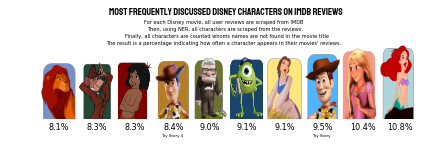

In [9]:
visualize_popular_disney(processed_names_per_movie, sentences_per_movie, names_per_movie)

**Visualize Movie Character Popularity**

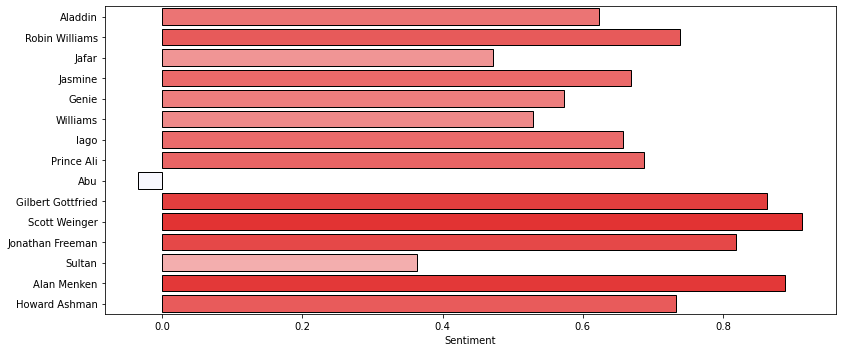

In [7]:
visualize_names(processed_names_per_movie["Aladdin"], save=None)

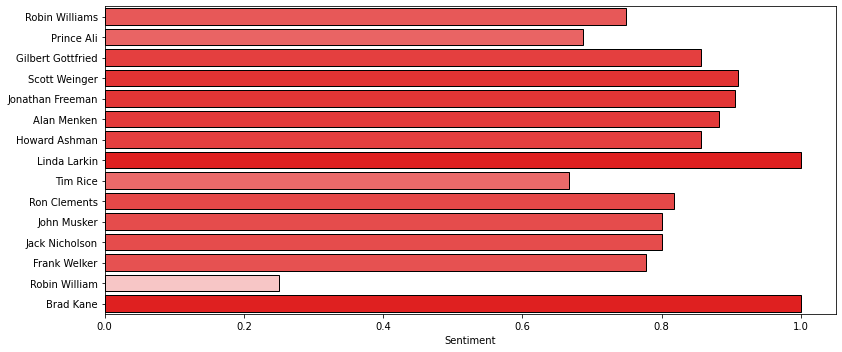

In [5]:
visualize_names(processed_names_per_movie["Aladdin"], save=None, people=True)

**Extract Popular Characters**

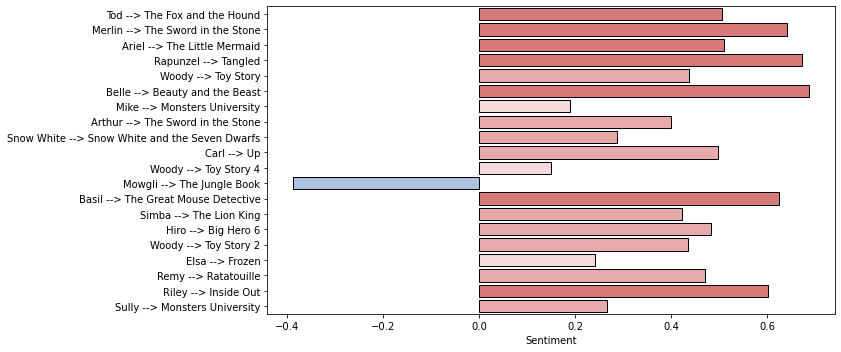

In [92]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=1000)
visualize_top_characters(result, n=20, save=False)

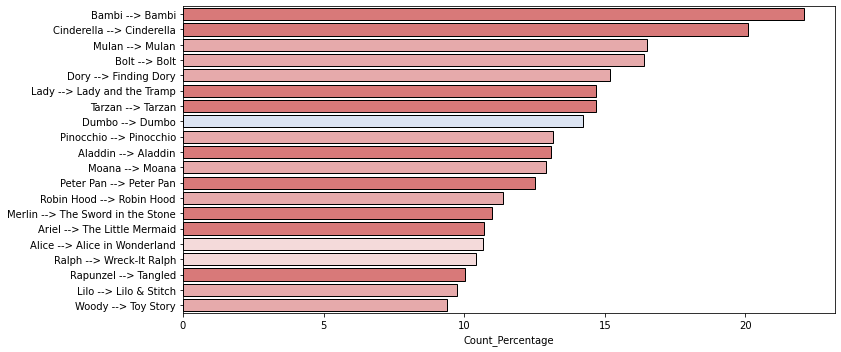

In [7]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, alternative_plot=True, save=False)

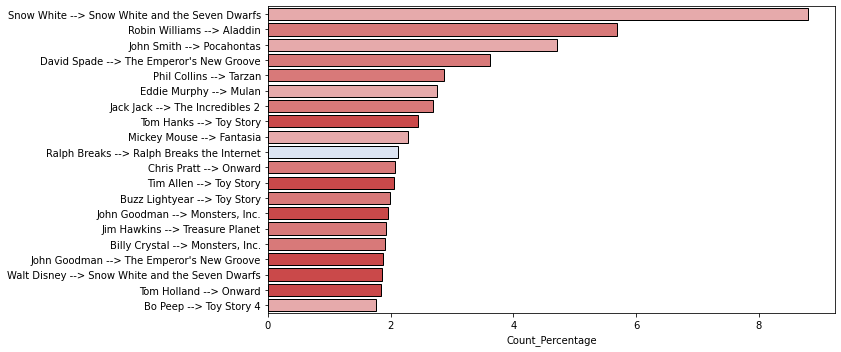

In [8]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=3000)
visualize_top_characters(result, n=20, alternative_plot=True, people=True, save=False)

**Name in Title**

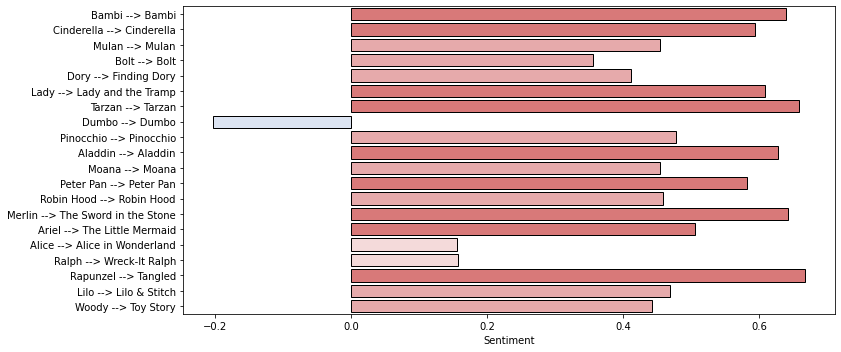

In [9]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, save=False)

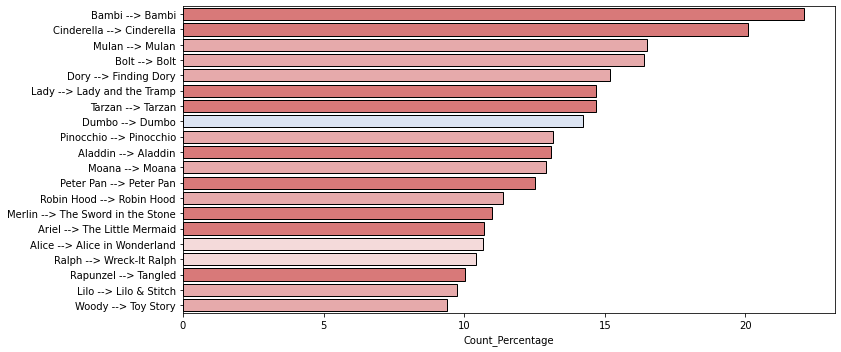

In [10]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=True, min_sentences=1000)
visualize_top_characters(result, n=20, alternative_plot=True, save=False)

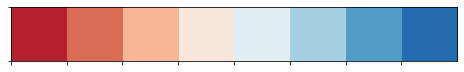

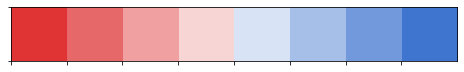

In [388]:
sns.palplot(sns.color_palette("RdBu", 8))
sns.palplot(sns.diverging_palette(12, 255, s=80, l=50, n=8))

**Visualize Names per Movie**

In [5]:
from PIL           import Image
from collections   import Counter

import matplotlib.pyplot    as plt
import matplotlib.image     as mpimg
import matplotlib.patches   as patches

from matplotlib.offsetbox      import AnchoredText
from mpl_toolkits.axes_grid1   import make_axes_locatable

In [140]:
result = extract_popular_characters(processed_names_per_movie, sentences_per_movie, names_per_movie, 
                                    name_in_title=False, min_sentences=1000)
to_plot = result.loc[result.Nr_Words > 1, :].head(10).copy()
to_plot = result.head(10).sort_values("Count_Percentage").copy()

In [110]:
to_plot = processed_names_per_movie["Aladdin"].copy().sort_values("Count", ascending=False)
to_plot = to_plot.loc[to_plot.Nr_Words > 1, :].head(10).sort_values("Count")

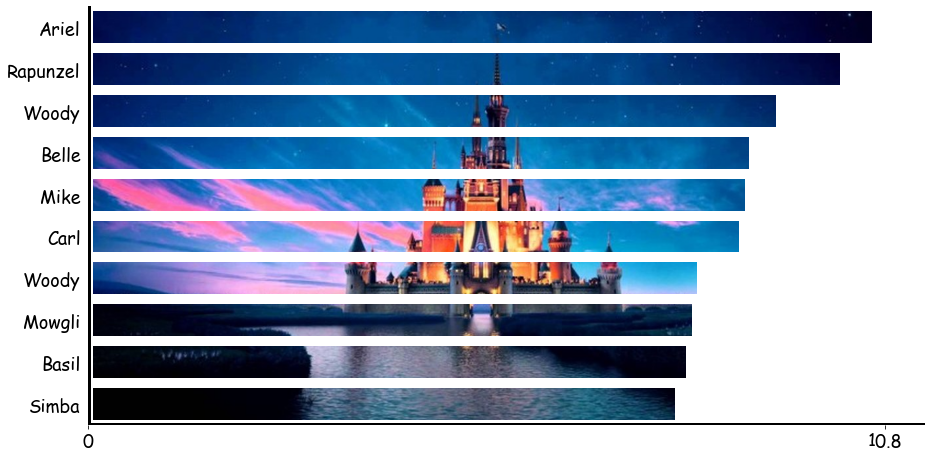

In [33]:


font = {'fontname':'Comic Sans MS'}

# Background image to be used, black if nothing selected
image_path = "../images/graph_masks/disney.jpg"
img = Image.open(image_path)

# Get size of image
width = img.size[0]
height = img.size[1]

# Create left part of graph ('top') and right part which overlays
# the image ('bottom')
to_plot['top'] = (to_plot["Count_Percentage"] * (width*0.99) ) / max(to_plot["Count_Percentage"]) 
to_plot['bottom'] = width - to_plot['top'] 

# Create the steps of the bars based on the height of the image
steps = height/len(to_plot)
y_pos = [(height/len(to_plot)/2) + (i * steps) for i in range(0, len(to_plot))]
# x_steps = width / len(to_plot)

# Plot figure
fig, ax = plt.subplots(figsize=(15, 15))

# First plot the image
plt.imshow(img, extent=[0, width*0.99, 0, height], zorder=1)

# Then plot the right part which covers up the right part of the picture
ax.barh(y_pos, to_plot['bottom'], left=to_plot['top'],height=steps, color='w',align='center',
        alpha=1,lw=2, edgecolor='w', zorder=2)

# Finally plot the bar which is fully transparent aside from its edges
ax.barh(y_pos, to_plot['top'], height=steps, fc=(1, 0, 0, 0.0), align='center',lw=10,
        edgecolor='white',zorder=3, color="black")

# Remove ticks
ax.yaxis.set_ticks_position('none') 
# ax.xaxis.set_ticks_position('none') 

# Set labels and location y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(list(to_plot['Word'].values), fontsize=18,**font)
ax.set_ylim(top=height)

ax.set_xticks([0, width])
ax.set_xticklabels([0, round(max(to_plot['Count_Percentage'].values), 1)], fontsize=18,**font)

# Make them with to remove any image line that may be left
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')

# Remove the left and bottom axis
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add a small patch that removes some of the extra background at the top
ax.add_patch(patches.Rectangle((0,height),width, 20,facecolor='white',linewidth = 0, zorder=3))

# Add left and bottom lines
plt.axvline(0, color='black', ymax=1, lw=5, zorder=4)
plt.axvline(width, color='white', ymax=1, lw=5, zorder=5)
plt.axhline(0, color='black', xmax=1, lw=5, zorder=6)
# plt.axhline(height, color="black", xmax=1, lw=3, zorder=7)

# # Create Title Box
# # This might be a temporary solution as 
# # makes_axes_locatable might lose its functionality
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("top", size="19%", pad=None)
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# at = AnchoredText("Aladdin", loc=10, pad=0,
#                   prop=dict(backgroundcolor="black",
#                             size=23, color="white", **font))
# cax.add_artist(at)
# cax.set_facecolor("black")   
# cax.spines['left'].set_visible(False)
# cax.spines['bottom'].set_visible(False)
# cax.spines['right'].set_visible(False)
# cax.spines['top'].set_visible(False)

# fig.set_size_inches(20, 40)
# # if save_name:
# #     plt.savefig(save_path+save_name+'.png', dpi = 300)

In [ ]:
sent = pd.DataFrame.from_records([sentences_per_movie]).T.reset_index()
sent.columns = ["Title", "Nr_Sentences"]
sent.sort_values("Nr_Sentences", ascending=False)